In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
ll ../data/mnist

In [ ]:
data_dir = (Path.cwd() / "../data/mnist").resolve()
train_data = data_dir / "mnist_train.csv"

Data above has columns of pixel location and rows of integer label.

Reminder about the feedforward equations:
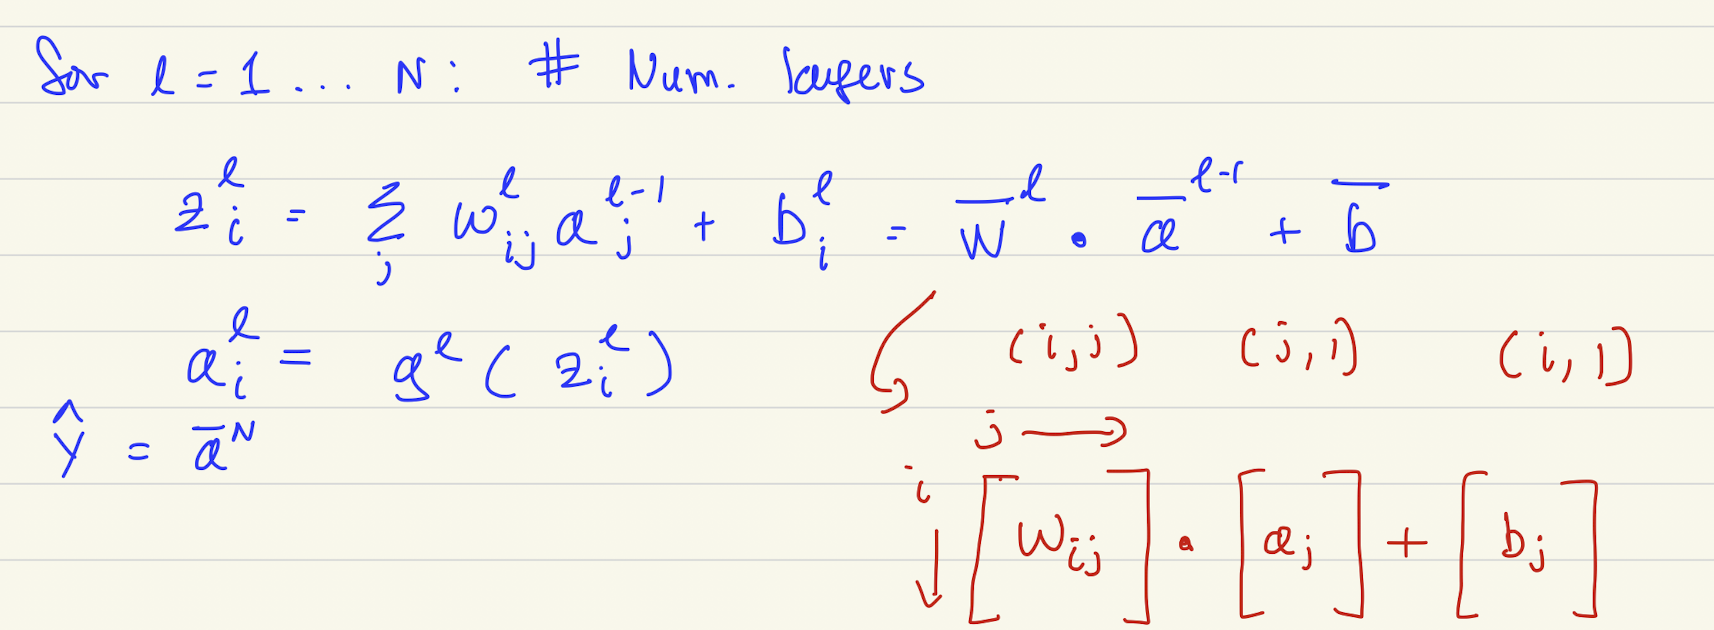

In [ ]:
x_train = np.loadtxt(
    train_data, delimiter=",", skiprows=1, usecols=np.arange(1, (28 * 28) + 1)
)
x_features = np.loadtxt(
    train_data, delimiter=",", usecols=np.arange(1, (28 * 28) + 1), max_rows=1, dtype=str
)
y_true_train = np.loadtxt(train_data, delimiter=",", skiprows=1, usecols=[0])


In [ ]:
x_features

Initialize for a toy problem first

In [ ]:
# Initialize weights and biases
weights = np.random.rand(5, 3, 3)
biases = np.random.rand(5, 3)

In [ ]:
weights[0, ...]

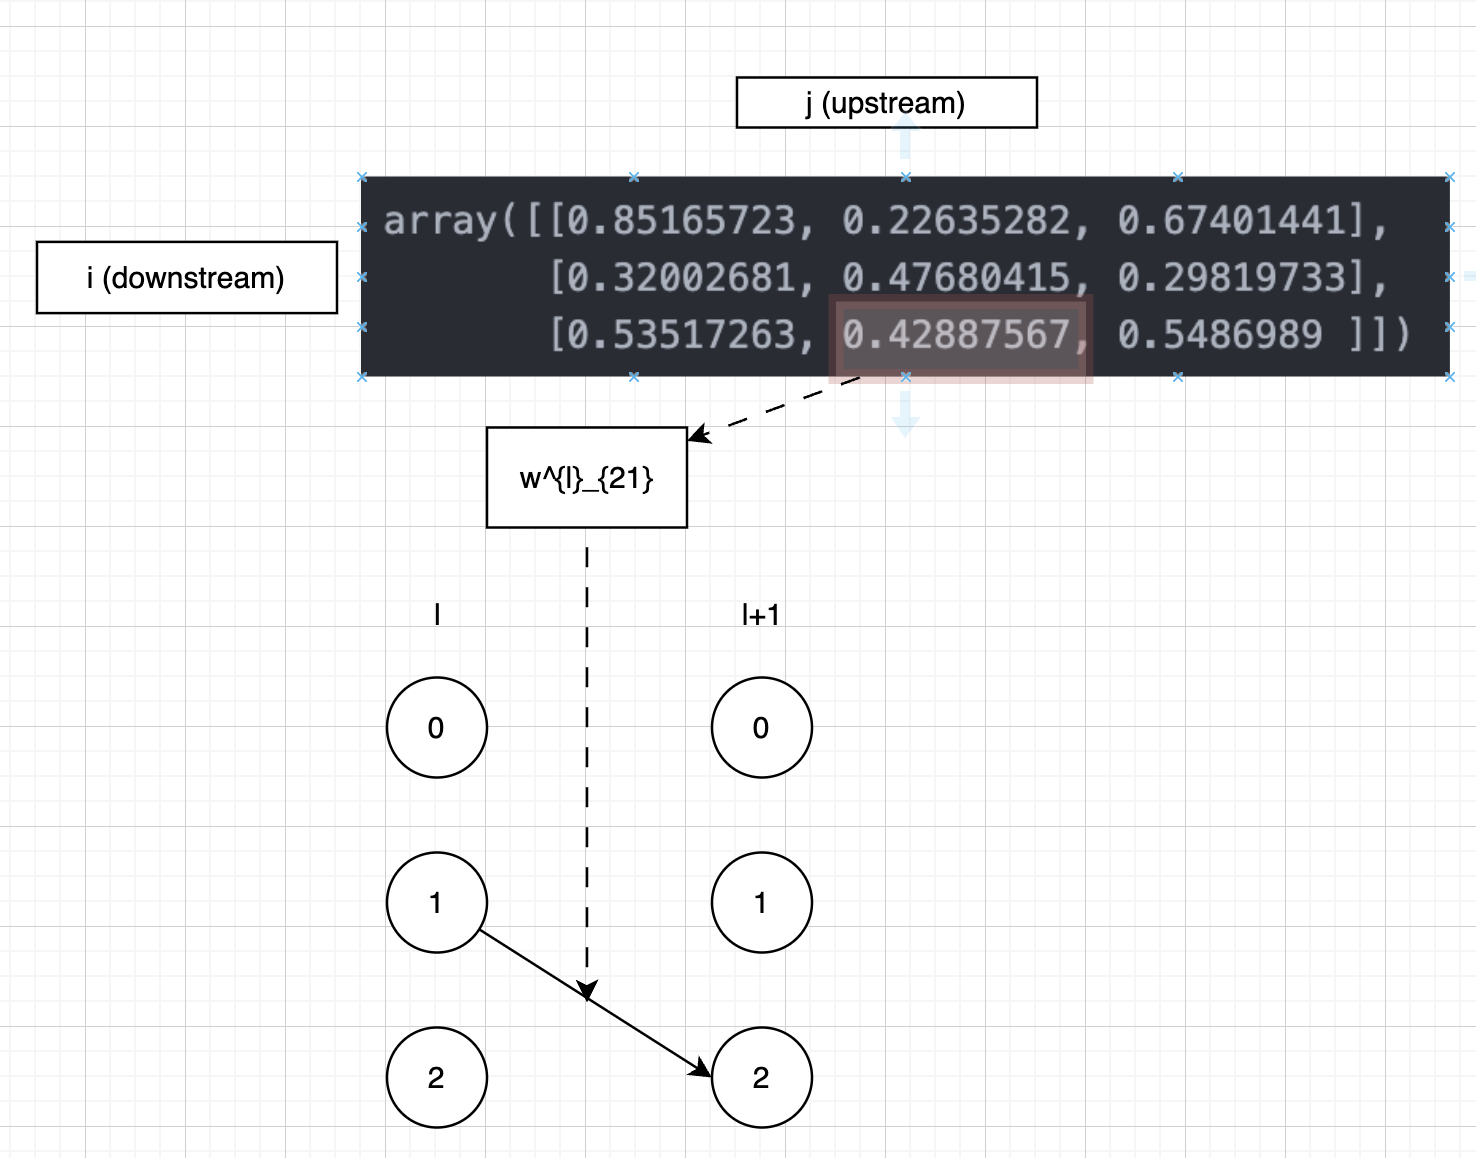

Initialize again for MNIST

In [ ]:
# Initialize hyperparameters
num_int_layers = 3
const_layer_height = 5 # Constant height for now

input_layer_height = len(x_features)
out_layer_height = 10 # 0...9

In [ ]:
# Create layer heights
layers = np.array([input_layer_height] + num_int_layers * [const_layer_height] + [out_layer_height])
layers

In [ ]:
# Initialize weights and biases
weights = [np.random.rand(downstream, upstream) for downstream, upstream in zip(layers[1:], layers[:-1])]
biases = [np.random.rand(downstream) for downstream in layers[1:]] # No bias in input data

In [ ]:
x_train

In [ ]:
def ReLU(x):
    return max(0,x)

def softmax(x, axis=-1):
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exps = np.exp(x_shifted)
    return exps / np.sum(exps, axis=axis, keepdims=True)

# Create vectorized functions
vec_relu = np.vectorize(ReLU)
vec_softmax = np.vectorize(softmax)

activation_funcs = num_int_layers * [vec_relu] + [vec_softmax] # nothing for input layer

In [ ]:
def feedforward(inp):

    # FIXME: make this into a class

    activations = [inp]
    pre_activations = []


    # Perform feedforward
    for l_idx in np.arange(0, len(layers) - 1, dtype=int): # Don't include input layer
        z_downstream = weights[l_idx] @ activations[l_idx] + biases[l_idx]
        a_downstream = activation_funcs[l_idx](z_downstream)

        # Store into lists
        pre_activations.append(z_downstream)
        activations.append(a_downstream)

    return activations, pre_activations

In [ ]:
# Do one inference
for train_ex in x_train[:1, :]:
    l_activation, l_pre_activations = feedforward(train_ex)

In [ ]:
def cost_func(y_true, y_pred, eps=1e-12):

    # Cross entropy
    # avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred))


def dir_cost_func(y_true, y_pred):
    return y_pred - y_true

def dir_activation(x):

    return 1

In [ ]:
def one_hot_encode(idx):

    vec = np.zeros((10,), dtype=int)
    vec[int(idx)] = 1

    return vec

In [ ]:
def sgd(old, eta, dir_c):

    return old - eta*dir_c

In [ ]:
def backprop(l_activation,y_true_train):

    back_prop_range = list(reversed(range(-len(layers) + 2, -1)))
    errors = []
    # Perform BP1, or error or output layer
    # one hot encode
    vec_true_train = one_hot_encode(y_true_train)
    errors.append(l_activation[-1] - vec_true_train)
    # final layer doesnt have activations

    for l_idx in back_prop_range:
        print(f"{l_idx=}")
        # derivative of sigma which is dir of ReLU is simply 1
        del_l = (weights[l_idx + 1].T @ errors[l_idx + 1]) * 1
        dir_Cb = del_l
        dir_Cw = l_activation[l_idx].reshape(-1,1) @ del_l.reshape(1,-1)

        # Add to beginning so idx works correctly
        errors.insert(0, del_l)

        # perform SGD
        weights[l_idx] = sgd(weights[l_idx], 0.05, dir_Cw)
        biases[l_idx] = sgd(biases[l_idx], 0.05, dir_Cb)

In [ ]:
back_prop_range = list(reversed(range(-len(layers) + 2, -1)))
# Numbers from -2, -3, -4, ...
# Dont include output or input layer
for idx, train_ex in enumerate(x_train[:1, :]):

    errors = []
    # Perform BP1, or error or output layer
    # one hot encode
    vec_true_train = one_hot_encode(y_true_train[idx])
    errors.append(l_activation[-1] - vec_true_train)
    # final layer doesnt have activations

    for l_idx in back_prop_range:
        # derivative of sigma which is dir of ReLU is simply 1
        del_l = (weights[l_idx + 1].T @ errors[l_idx + 1]) * 1
        dir_Cb = del_l
        dir_Cw = l_activation[l_idx].reshape(-1,1) @ del_l.reshape(1,-1)

        # Add to beginning so idx works correctly
        errors.insert(0, del_l)

        # perform SGD
        weights[l_idx] = sgd(weights[l_idx], 0.05, dir_Cw)
        biases[l_idx] = sgd(biases[l_idx], 0.05, dir_Cb)


In [ ]:
l_activation[-1]

In [ ]:
# Do one inference
for idx, train_ex in enumerate(x_train):
# for idx, train_ex in enumerate(x_train[:1, :]):
    l_activation, l_pre_activations = feedforward(train_ex)
    backprop(l_activation,y_true_train[idx])